# ATF4 Project
## Preliminary analysis of all-atom MD simulatins of the ATF4 protein
### This contains all relevant analysis in one file. Loading the whole trajectory is too painful.

### Chuan Ping,  Urval Patel, Dr. Roche, Dr. Potoyan

In [1]:
import numpy as np
import matplotlib.pyplot as plt

import mdtraj as md

from contact_map import ContactFrequency, ContactDifference

import nglview as nv
import ipywidgets

%matplotlib inline
%config InlineBackend.figure_format='retina'

plt.style.use('bmh')

In [2]:
ns_per_frame = 0.02
cutoffValue  = 0.25 # Above this value, a "contact" is deemed valid. 
predominance_2nd_structure = 0.5 # This is arbitrary! 

## Logistics and Summary

### Simulations done so far:

Need to be filled

## Loading and Showing the Equilibriated Trajectory

In [4]:
%%time
traj1 = md.load_hdf5('/Users/cping/Desktop/ATF4/atf_short.h5') 

# This step may take an ungodly amount of time. Centering coordinates is more for visualization.
# traj1.center_coordinates(traj1)
total_frame = traj1.n_frames
print("The total number of frames is: " + str(total_frame))
print("The total number of nanoseconds is " + str(int(ns_per_frame * total_frame)))

The total number of frames is: 1794
The total number of nanoseconds is 35
CPU times: user 397 ms, sys: 54.4 ms, total: 451 ms
Wall time: 459 ms


In [6]:
%%time
# Loading the trajectory is really painful, so let's get a shortened version of such. 

# This defines the simplified trajectory
# traj1_simplified = traj1[::100]
#traj1_simplified.save_hdf5('traj1_simplified.h5')

traj1_simplified = md.load_hdf5('/Users/cping/Desktop/ATF4/atf_short.h5') 
total_frame = traj1_simplified.n_frames
print("The total number of frames is: " + str(total_frame))
print("The total number of nanoseconds is " + str(int(ns_per_frame * total_frame)))

The total number of frames is: 1794
The total number of nanoseconds is 35
CPU times: user 364 ms, sys: 33.3 ms, total: 398 ms
Wall time: 399 ms


In [8]:
lastframe = traj1_simplified[-1]
lastframe.save("/Users/cping/Desktop/ATF4/atf4_last_frame.pdb")

In [18]:
# This is used to visualize the entire trajectory.

# show1 = nv.show_mdtraj(traj1)
# show1

show1_simplified = nv.show_mdtraj(traj1_simplified)
show1_simplified

NGLWidget(max_frame=1793)

In [19]:
%%time
# topology1 = traj1.topology
# print(topology1)

topology1 = traj1_simplified.topology
print(topology1)

<mdtraj.Topology with 1 chains, 352 residues, 5380 atoms, 5430 bonds>
CPU times: user 309 µs, sys: 184 µs, total: 493 µs
Wall time: 390 µs


## Display of Rg and RMSD plots

In [5]:
%%time
# Select the Alpha Carbon atom of each residue of the three replicas
ca_1      = traj1_simplified.top.select('name CA')
ca_traj_1 = traj1_simplified.atom_slice(ca_1)

CPU times: user 124 ms, sys: 5.78 ms, total: 130 ms
Wall time: 179 ms


In [6]:
%%time
# Calculate the RMSD and Rg of three replicas
rmsd_1   = md.rmsd(ca_traj_1, ca_traj_1[0])
rg_1     = md.compute_rg(ca_traj_1)

CPU times: user 29.6 ms, sys: 3.01 ms, total: 32.6 ms
Wall time: 31.2 ms


Text(0.5, 1.0, 'Distribution of Rg for the ATF4 Protein')

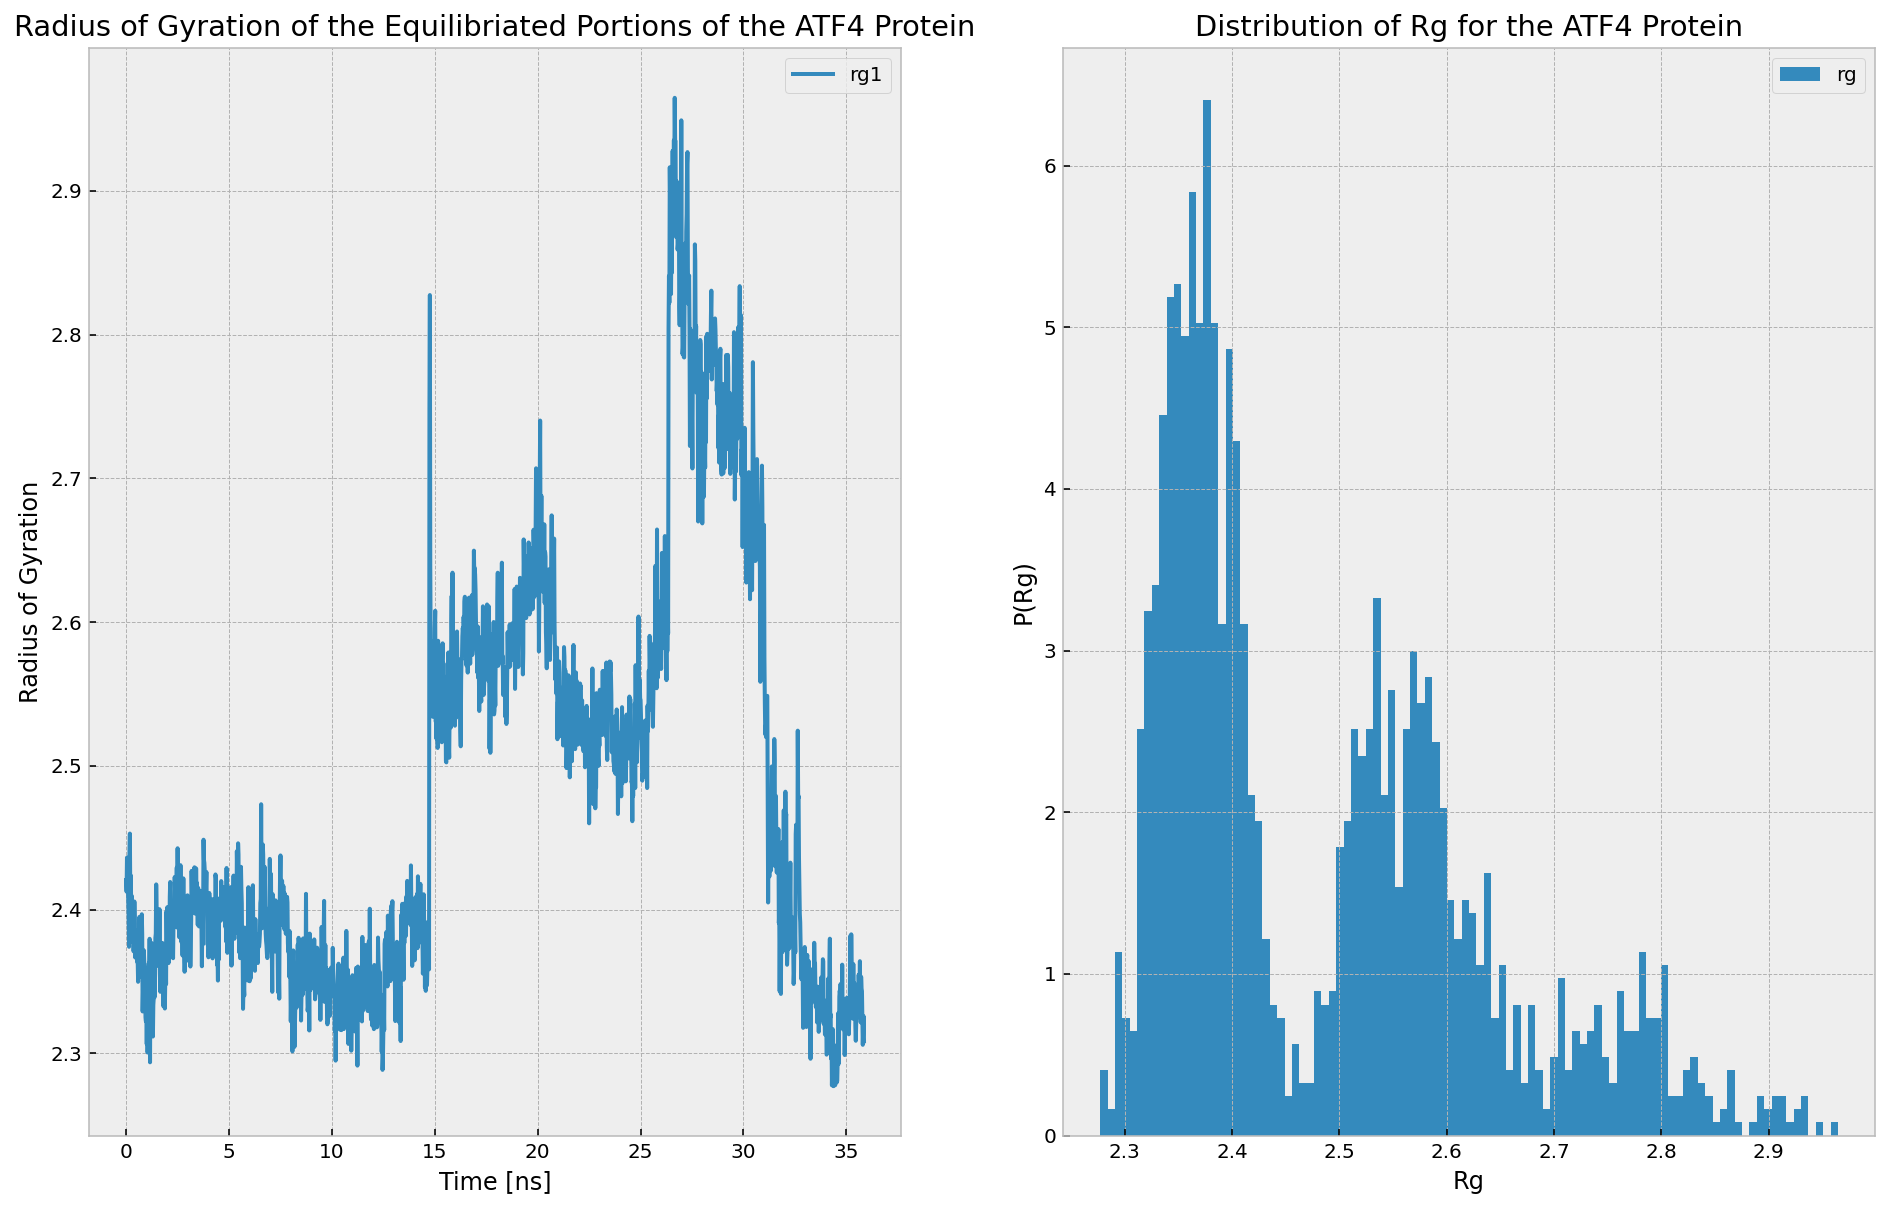

In [7]:
# Displays the radius of gyration of the trajectory
fig, (ax1, ax2)  = plt.subplots(ncols=2, figsize=(16, 10))
time = ns_per_frame * np.arange(len(rg_1))

ax1.plot(time, rg_1)
ax2.hist(rg_1, density=True, bins=100, label='rg')
ax1.legend(['rg1'])
ax2.legend(['rg'])
ax1.set(xlabel='Time [ns]', ylabel='Radius of Gyration') 
ax2.set(xlabel='Rg', ylabel='P(Rg)') 

ax1.set_title('Radius of Gyration of the Equilibriated Portions of the ATF4 Protein')
ax2.set_title('Distribution of Rg for the ATF4 Protein')

Text(0.5, 1.0, 'Distribution of RMSD for the ATF4 Protein')

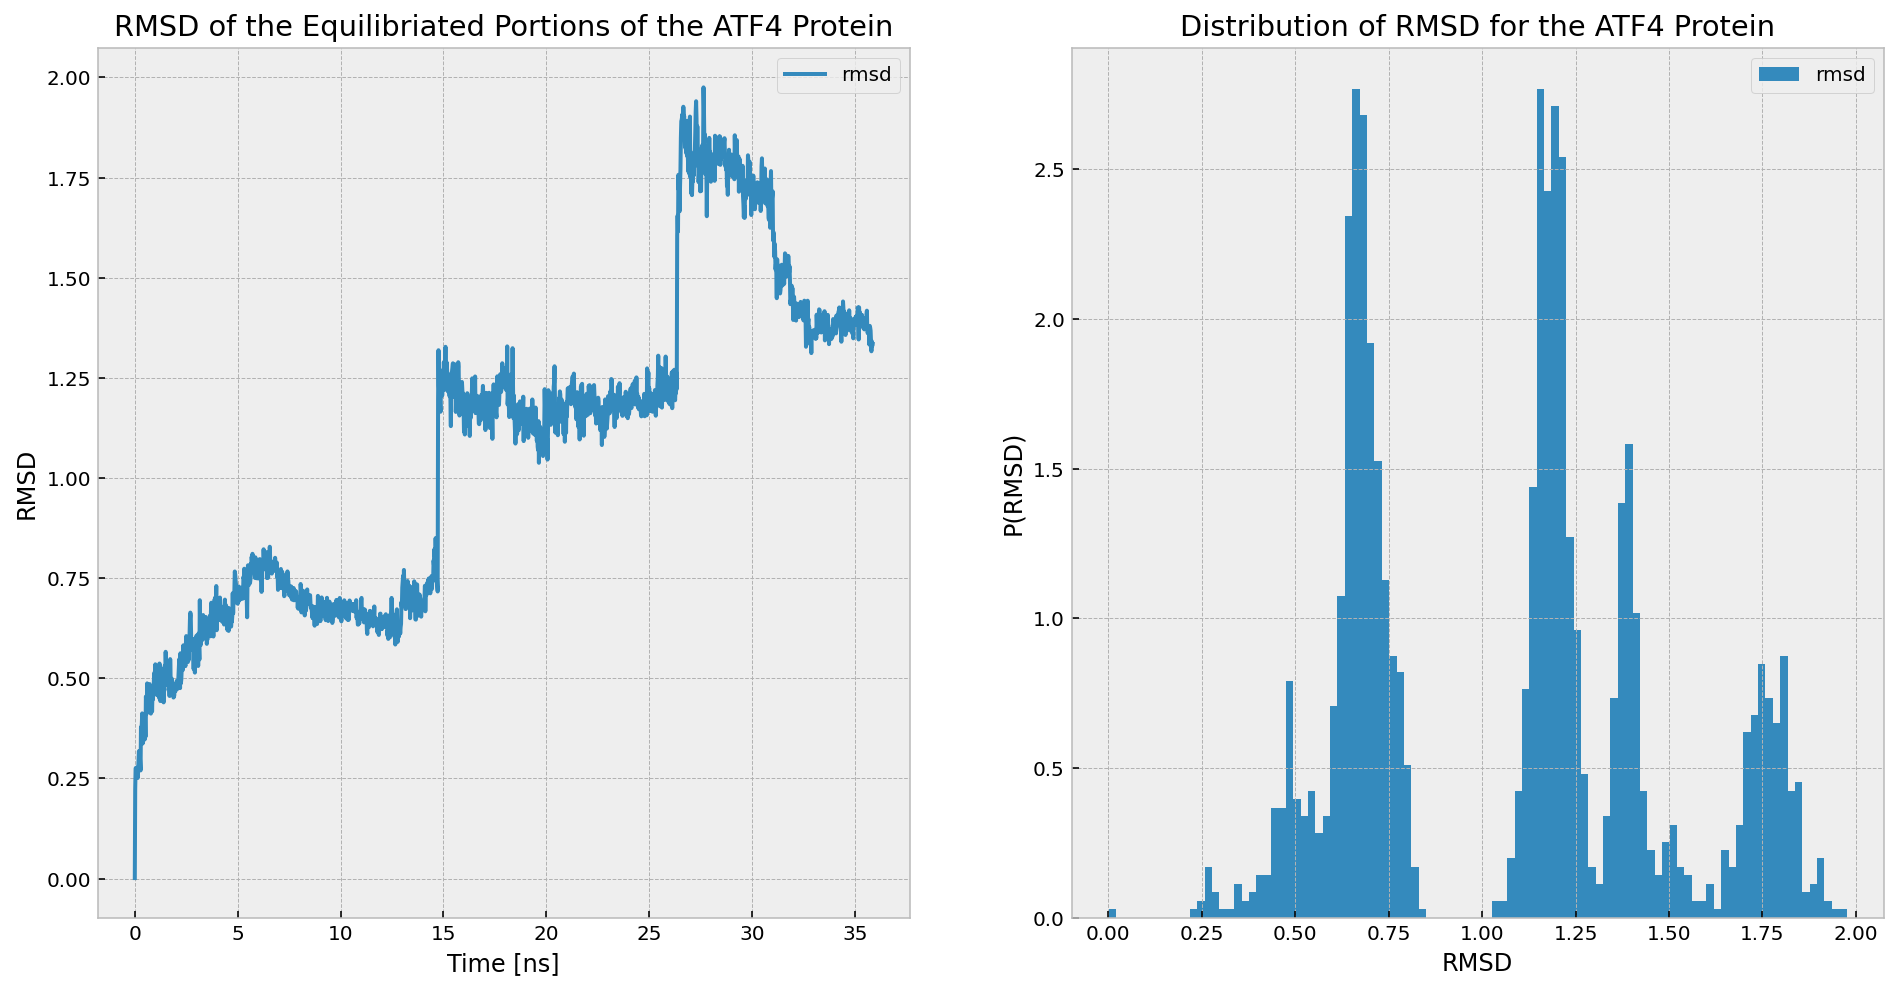

In [9]:
# Displays the radius of gyration of the trajectory
# Note that the RMSD plot is arbitrary. It only needs to show three roughly equilibriated portions. 
fig, (ax1, ax2)  = plt.subplots(ncols=2, figsize=(16,8))
time = ns_per_frame*np.arange(len(rmsd_1))

ax1.plot(time, rmsd_1)
ax2.hist(rmsd_1, density=True, bins=100, label='RMSD')
ax1.legend(['rmsd'])
ax2.legend(['rmsd'])
ax1.set(xlabel='Time [ns]', ylabel='RMSD') 
ax2.set(xlabel='RMSD', ylabel='P(RMSD)') 

ax1.set_title('RMSD of the Equilibriated Portions of the ATF4 Protein')
ax2.set_title('Distribution of RMSD for the ATF4 Protein')

## Secondary Structure Analysis of the Entire Protein
May not be as useful as the TAD analysis, to be honest.

In [63]:
%%time
# BE VERY AWARE: this can KILL the kernel.
# traj1_simplest = traj1[::500]
secondary_structure_1 = md.compute_dssp(traj1_simplified, simplified=True)
print(len(secondary_structure_1[0]))

352
CPU times: user 1.03 s, sys: 7.15 ms, total: 1.04 s
Wall time: 1.04 s


In [67]:
def generate_2nd_structure(traj_secondary_structure, array_of_types):
    """
    Takes a trajectory and compute the secondary structure frequencies of all residues.
    
    traj: the input trajectory to be analyzed
    array_of_types: an array containing symbols representing different secondary structures
    
    output: a dictionary. First dimension = len(array_of_types).Second dimension = traj.n_residues()
    """
    # Creates an empty dictionary for output
    output_dict = {}
    number_of_frames = len(traj_secondary_structure[0])
    number_of_residues = len(traj_secondary_structure)
    
    # Iterates over the input array
    for types in array_of_types:
        count_list = []
        
        # Iterates over the frames in the input trajectory
        for x in range(number_of_frames):
            count = 0
            
            # Iterates over the number of residues in the input trajectory
            for y in range(number_of_residues): 
                
                # Sums up the types of secondary structure and divide it by the total number of frames
                count += np.sum(np.char.count(traj_secondary_structure[y][x], types))
            count_list.append(count / number_of_residues)    
        output_dict[types] = count_list
                              
    return output_dict

In [92]:
def structured_residue(traj_secondary_structure, type_of_2nd_structure, prevalence):
    """
    Produces a list of residue indices whose corresponding residue in the trajectory predominates
    
    traj: the input trajectory to be analyzed
    type_of_2nd_structure: the type of secondary structure to be counted
    prevalence: the percentage of a certain secondary structure of a residue, above which the residue is
                determined to be "predominant" with that secondary structure
                
    output: a list of residue indices
    """
    output_list = []
    number_of_frames = len(traj_secondary_structure)
    number_of_residues = len(traj_secondary_structure[0])
    
    # Iterates over the residues in the input trajectory
    for x in range(number_of_residues):
        count_of_certain_type = 0
        
        # Iterates over the frames
        for y in range(number_of_frames):
            if traj_secondary_structure[y][x] == type_of_2nd_structure: count_of_certain_type += 1
        
        # Appends the index + 1 (residues start with MET1) to the list if deemed predominant
        if (count_of_certain_type / number_of_residues) > prevalence: output_list.append(x + 1) 
    
    return output_list

In [85]:
%%time
array_of_types = ['C','H','E','NA']
dict_2nd_structures = generate_2nd_structure(secondary_structure_1, array_of_types)

CPU times: user 25.7 s, sys: 29.3 ms, total: 25.8 s
Wall time: 25.8 s


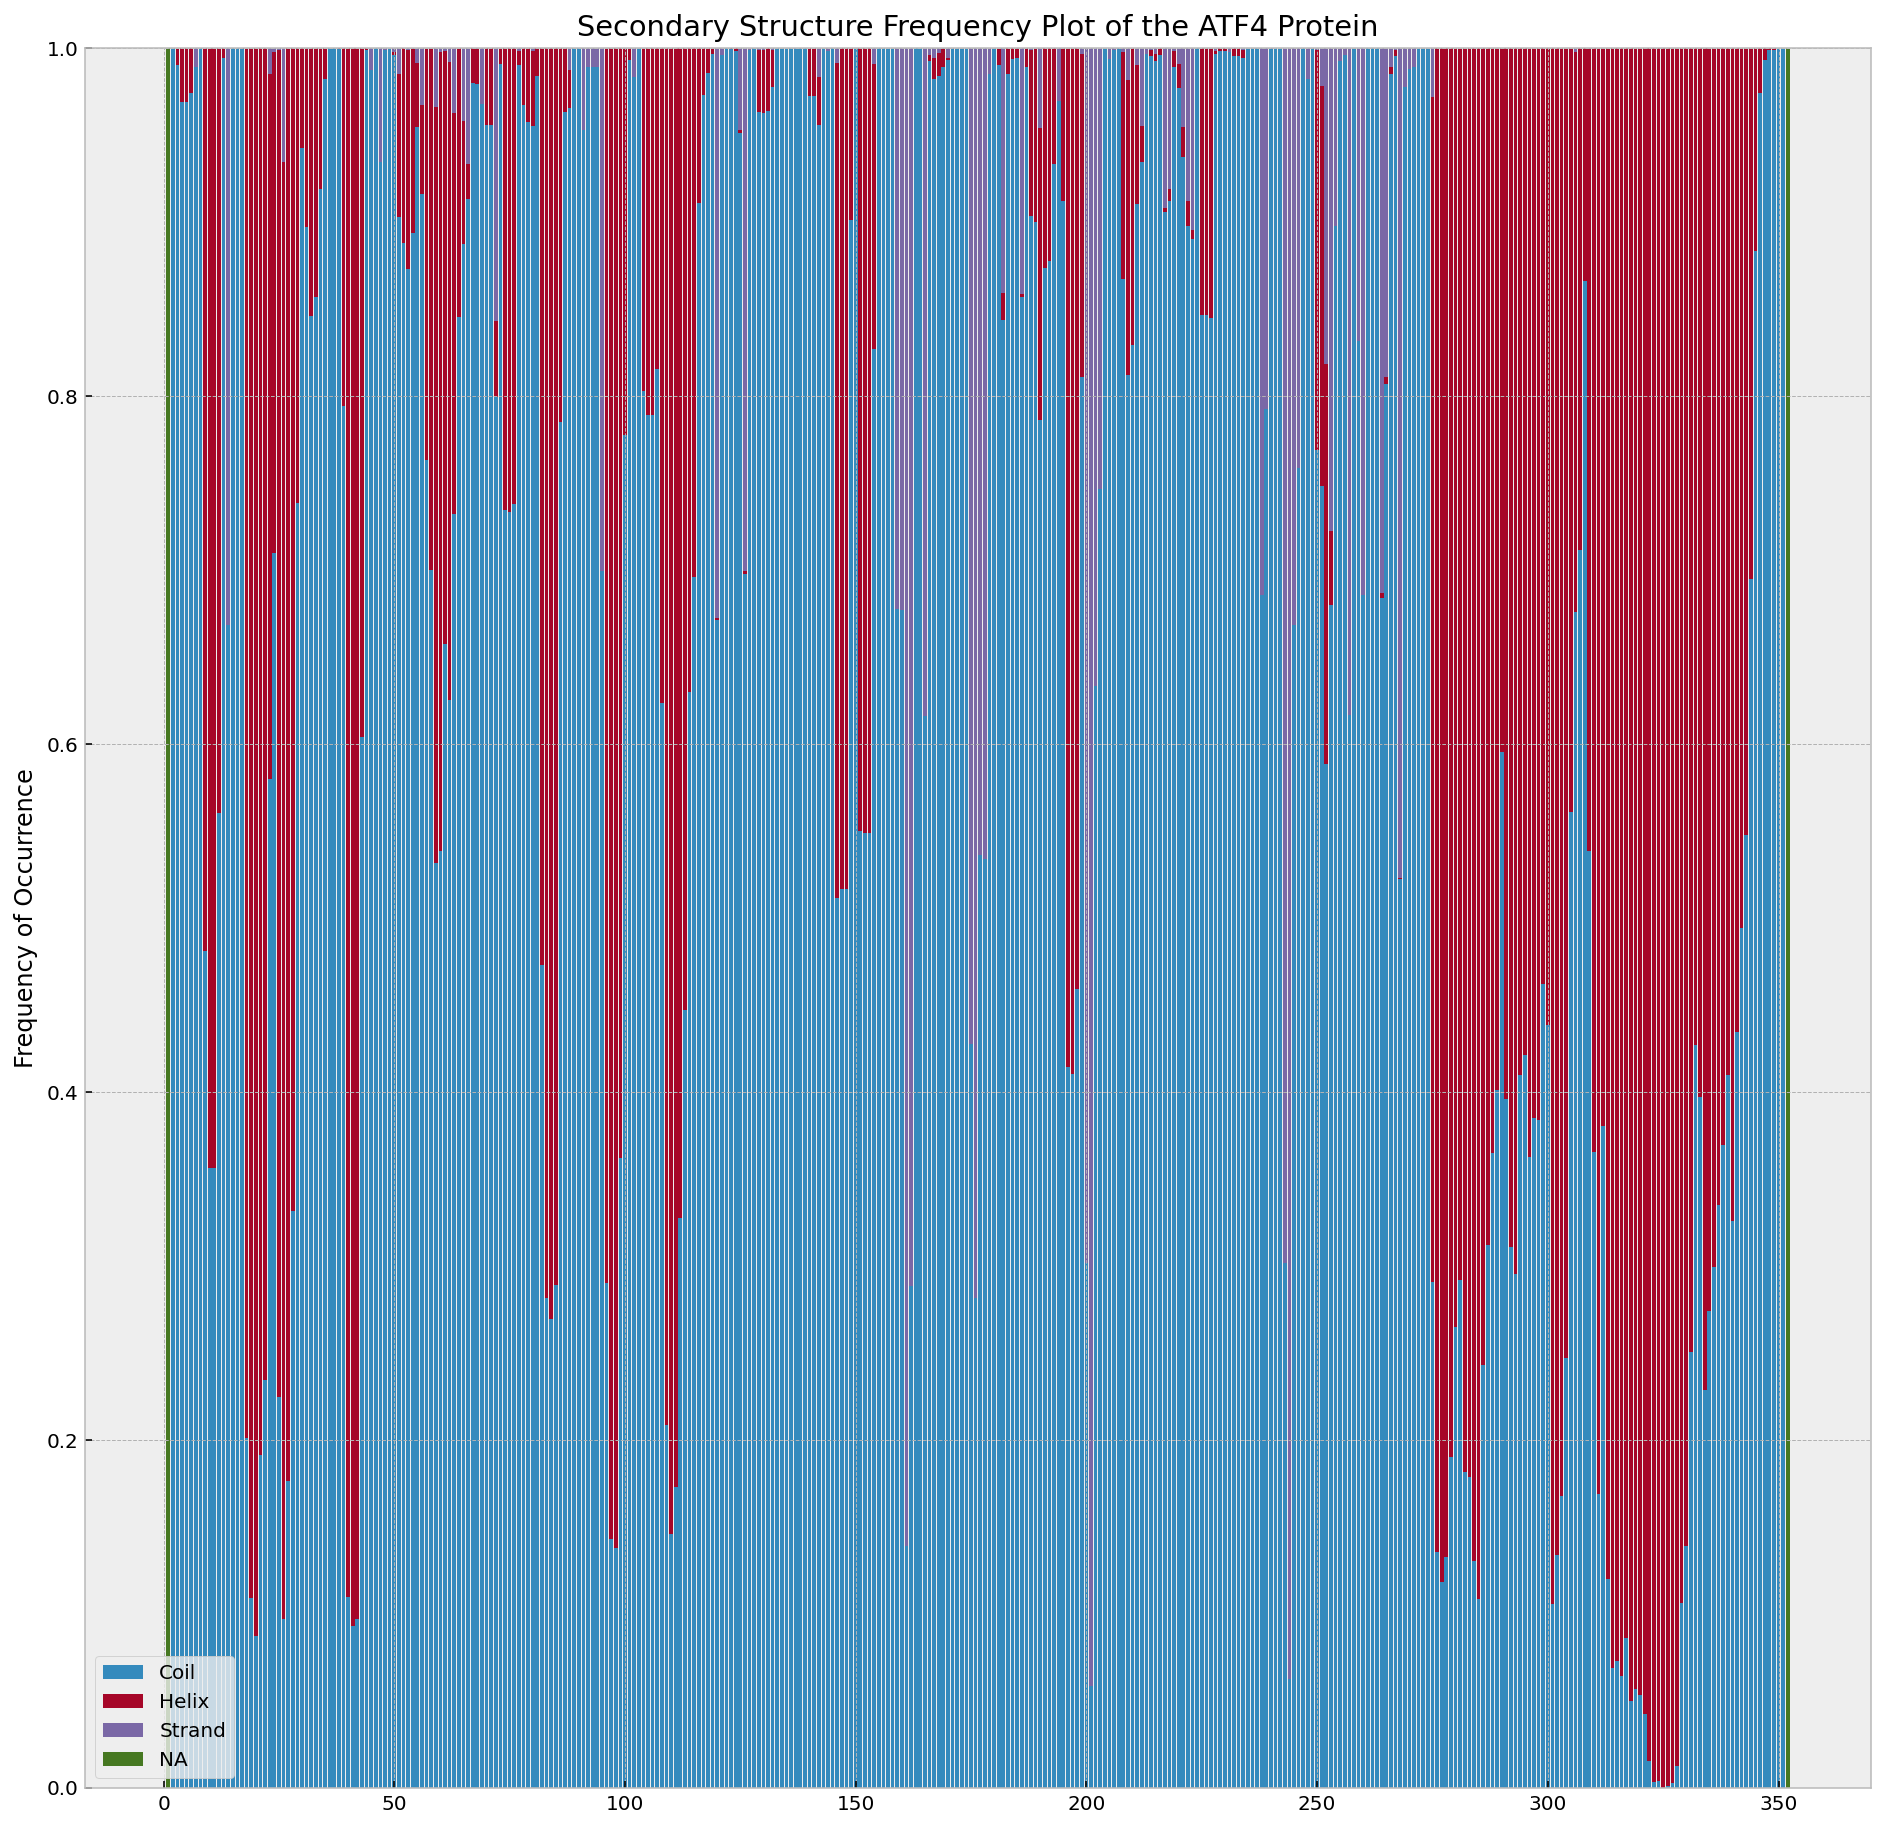

In [69]:
x_1 = dict_2nd_structures['C'] 
x_2 = dict_2nd_structures['H']
x_3 = dict_2nd_structures['E']
x_4 = dict_2nd_structures['NA']

# Note here! The x-axis starts at 1, not 0. This conforms to the residue index which starts at MET1
bins = list(range(1, len(secondary_structure_1[0]) + 1))

fig, ax = plt.subplots(figsize=(16,16))
ax.bar(bins, x_1, label="Coil")
ax.bar(bins, x_2, bottom=x_1,label="Helix")
ax.bar(bins, x_3, bottom=np.array(x_1) + np.array(x_2),label="Strand")
ax.bar(bins, x_4, bottom=np.array(x_1) + np.array(x_2) + np.array(x_3),label="NA")

ax.set_ylabel('Frequency of Occurrence')
ax.set_title('Secondary Structure Frequency Plot of the ATF4 Protein')
ax.legend()

plt.show()

## Contact Analysis

In [13]:
# This crudely written function is called to remove duplicate residues in a list.

def removeDuplicates(list_input):
    """
    Remove duplicates in a list. This is used to prevent add_representation from malfunctioning
    due to one residue may have more than one interactions with others
    
    list: the original list that may or may not contain duplicates
    
    output: a list without replicates
    """
    output = []
    output.append(x) for x in list_input if x not in output
    return output

In [14]:
# This function returns a list that can be quoted in visualization

def getContactIndex(contacts, topology, region1, region2, cutoffValue):
    """
    contacts: the contact map of the trajectory
    topology: the topology of the trajectory
    region1/2: the regions of residues of interest, as a range
    cutoffValue: the threshold of level of contacts
    
    returns a list containing the residue numbers of the residues that are in contact(this is for visualization)
    """
    resid_1_list = [] # Creates an empty list storing values of the residues
    resid_2_list = []
    for resid1 in region1:
        for contact in contacts.residue_contacts.most_common(topology.residue(resid1)):
            if contact[1] > cutoffValue and contact[0][1].index in region2:
                resid_1_list.append(contact[0][0].index + 1) # +1 to compensate for list starting with 0
                resid_2_list.append(contact[0][1].index + 1)
    return removeDuplicates(resid_1_list), removeDuplicates(resid_2_list)

In [15]:
%%time
# Writes the contact map between regions of interest into an output file

def contactBetweenRegions(contacts, topology, region1, region2, cutoffValue, outputFileName):
    """
    contacts: the contact map of the trajectory
    topology: the topology of the trajectory
    region1/2: the regions of residues of interest, as a range
    cutoffValue: the threshold of level of contacts
    
    returns 
    1) a txt file outlining important contacts between two regions of interest in the protein
    2) a list containing the residue numbers of the residues that are in contact(this is for visualization)
    """
    resid_1_list = [] # Creates two emply lists storing indices of the residues
    resid_2_list = []
    
    with open(outputFileName, 'w') as output:
        output.write(outputFileName + '\n\n')
        for resid1 in region1:
            for contact in contacts.residue_contacts.most_common(topology.residue(resid1)):
                if contact[1] > cutoffValue and contact[0][1].index in region2:
                    resid_1_list.append(contact[0][0].index)
                    resid_2_list.append(contact[0][1].index)
                    output.write(str(contact) + '\n\n')

CPU times: user 3 µs, sys: 0 ns, total: 3 µs
Wall time: 5.25 µs


In [58]:
def contact_dict(topology, contact, list_of_contacts, cutoffValue):
    """
    Produces a dictionary of the contacts whose value is above cutoffValue; the residue index is in the input list
    
    topology: the topology of the protein of interest
    contact: the contact information of the relevant residues
    list_of_contacts: produce of the getContactIndex function
    
    return: A dictionary. Key = residue index + 1; Value = a list containing the contact pairs and the contact frequency
            note that the contact frequency needs a better definition (May 10)
    """
    ranked_list = [] # Defines the output list
    dict_for_rank = {}
    
    # Iterates over all in list_of_contacts
    for residue_index in list_of_contacts:
        
        # Obtains the entire list of contacts for a specific residue index for further procession
        contact_list_for_residue = contact.residue_contacts.most_common(topology1.residue(residue_index))
        
        # Initiates a list to be written into the dictionary
        list_to_dict = []
        
        # Iterates over the pair of contacts in the list
        for contactPair in contact_list_for_residue:
            if contactPair[1] > cutoffValue:
                list_to_dict.append(contactPair)
        # Adds the now-valid contact list of the specific residue into the dictionary
        # Note that the dictionary key must have +1 for the residue index, for the residue index starts at 0 but
        # the first residue is always MET1 hence having an index 1. 
        dict_for_rank[residue_index + 1] = list_to_dict
        
    return dict_for_rank

In [50]:
%%time
# Loads the simplified version or it may risk KILLING the kernel. 
traj1_contacts = ContactFrequency(traj1_simplified)
# print(traj1_contacts)

CPU times: user 1min 25s, sys: 406 ms, total: 1min 25s
Wall time: 1min 25s


In [51]:
# Testing block; Urval can ignore this. 
print(traj1_contacts.residue_contacts.most_common(topology1.residue(5)))

[([HIS43, PHE6], 0.3907469342251951), ([VAL269, PHE6], 0.32274247491638797), ([LEU12, PHE6], 0.32051282051282054), ([MET1, PHE6], 0.3076923076923077), ([ALA270, PHE6], 0.30379041248606464), ([MET268, PHE6], 0.2653288740245262), ([GLY265, PHE6], 0.25418060200668896), ([VAL11, PHE6], 0.23968784838350055), ([LYS289, PHE6], 0.23411371237458195), ([PHE94, PHE6], 0.2302118171683389), ([PHE6, GLU39], 0.21460423634336678), ([PHE6, ALA271], 0.19230769230769232), ([LEU91, PHE6], 0.18561872909698995), ([LYS267, PHE6], 0.1633221850613155), ([GLU266, PHE6], 0.1633221850613155), ([GLU93, PHE6], 0.10535117056856187), ([GLU3, PHE6], 0.10144927536231885), ([PHE6, VAL40], 0.09531772575250837), ([MET285, PHE6], 0.08639910813823858), ([SER179, PHE6], 0.0758082497212932), ([PHE6, ASN288], 0.06075808249721293), ([LYS42, PHE6], 0.045707915273132664), ([LYS281, PHE6], 0.039576365663322184), ([ILE102, PHE6], 0.03288740245261984), ([PHE44, PHE6], 0.02564102564102564), ([SER9, PHE6], 0.022853957636566332), ([PHE

CPU times: user 7.58 s, sys: 99.6 ms, total: 7.68 s
Wall time: 7.78 s


Text(0, 0.5, 'Residue')

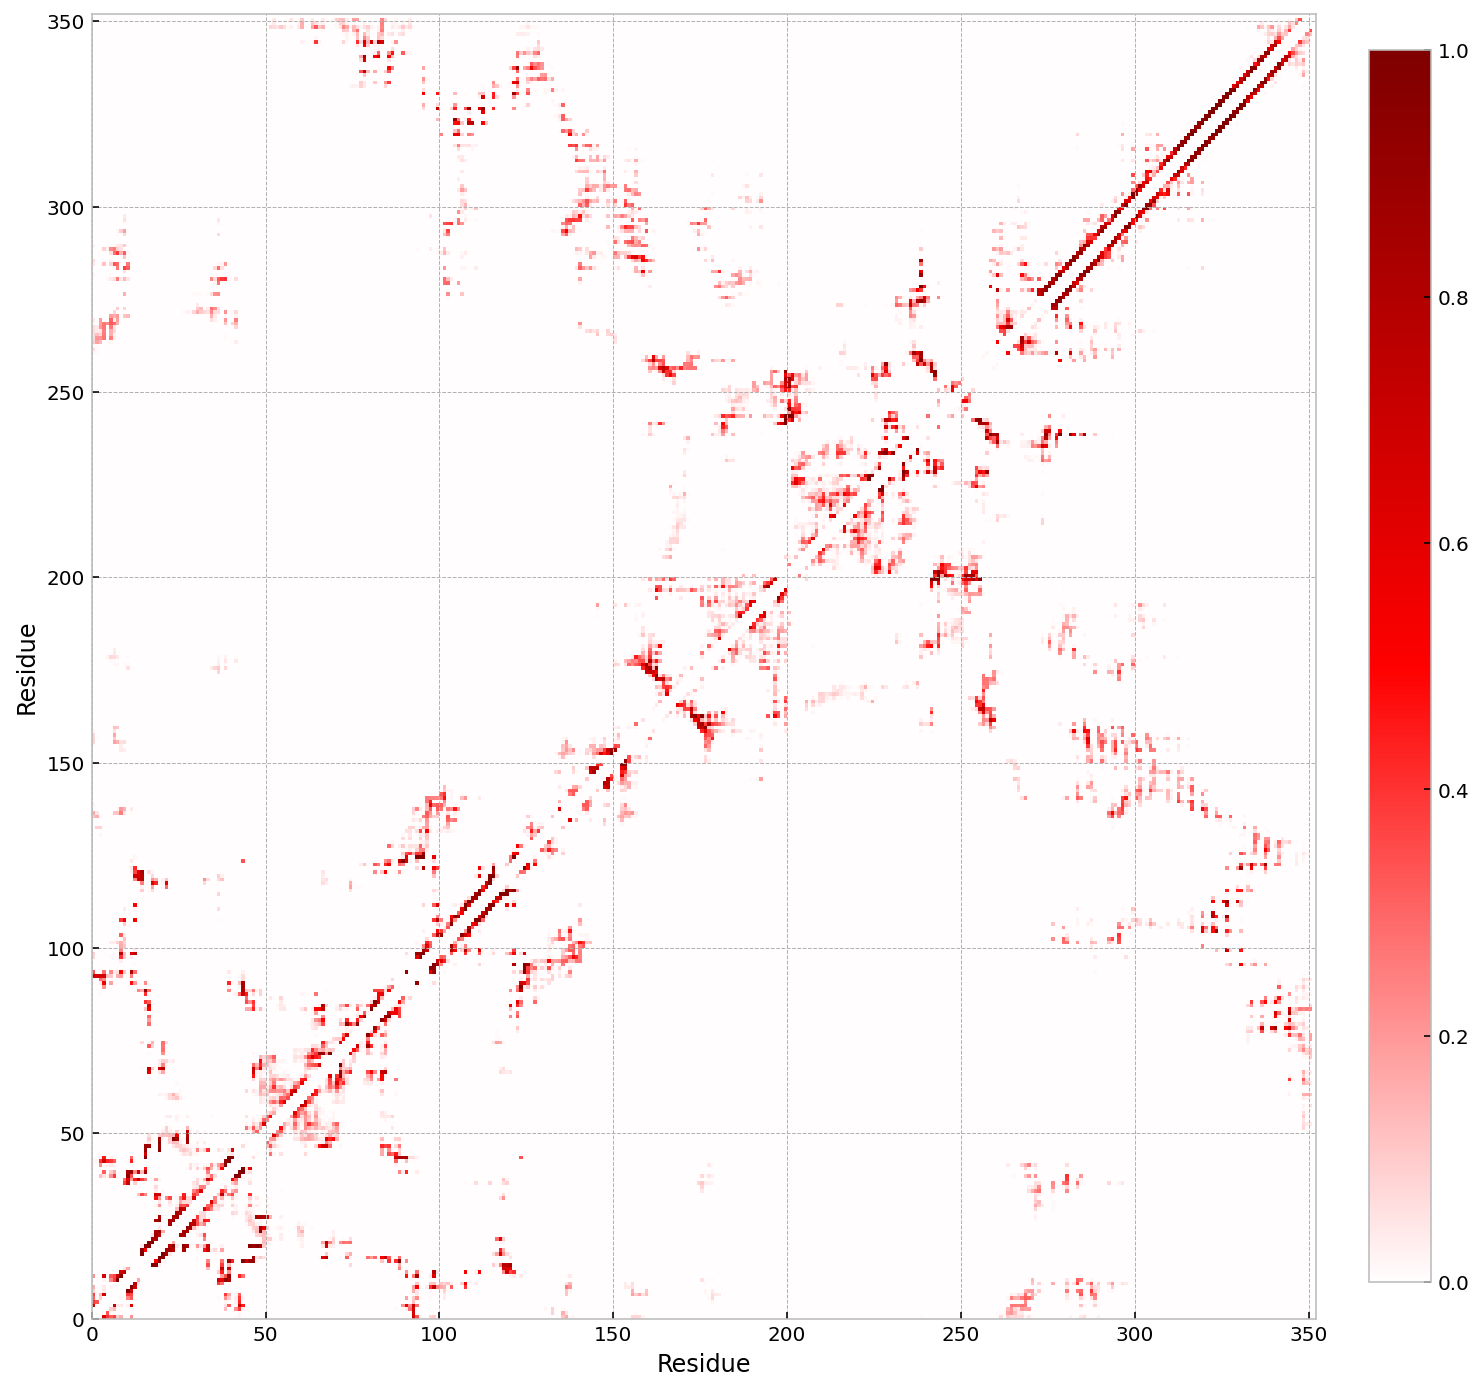

In [15]:
%%time
# Creates the contact map plot of the entire ATF4 protein.
fig, ax = traj1_contacts.residue_contacts.plot(figsize=(12,12))
plt.xlabel("Residue")
plt.ylabel("Residue")

In [21]:
# This specifies the residue numbers of the four visual regions of the ATF4 protein.
# Rationale drawn from Steven's paper. Note that all residues were counted, although his paper does not indicate so.

tad_1  = range(0,155)
tad_2  = range(156,275)
bzip_1 = range(276,300)
bzip_2 = range(301,351)

In [ ]:
# This block of code is used to produce the txt files.

contactBetweenRegions(traj1_contacts, topology1, tad_1, bzip_1, cutoffValue, "tad_1_bzip_1.txt")
contactBetweenRegions(traj1_contacts, topology1, tad_2, bzip_2, cutoffValue, "tad_2_bzip_2.txt")
contactBetweenRegions(traj1_contacts, topology1, tad_1, tad_2, cutoffValue, "tad_1_tad_2.txt")
contactBetweenRegions(traj1_contacts, topology1, bzip_1, bzip_2, cutoffValue, "bzip_1_bzip_2.txt")

In [ ]:
# Pseudocode for Contact Analysis: a new map of construct

# Goal: Produce a graph by which the pairs having highest contact frequency are listed.
# Parameters needed: trajectory, contact map(the entire whatever list)
    
# List the pairs by order
# make a matplotlib histogram? about the contact frequency. Then, this is pinned against the secondary structure in the TAD region.



In [104]:
%%time
# This is the list of the TAD_1 section with high contact frequency with bzip_1 
resid_1_list = getContactIndex(traj1_contacts, topology1, tad_1, bzip_1, cutoffValue)[0]
print(resid_1_list)

# This is the list of the TAD_2 section with high contact frequency with bzip_2 
resid_2_list = getContactIndex(traj1_contacts, topology1, tad_2, bzip_1, cutoffValue)[0]
print(resid_2_list)

# This is the list containing all residues that has a helical structure. 
helices_list = structured_residue(secondary_structure_1, 'H', predominance_2nd_structure)
print(helices_list)

[7, 10, 11, 37, 102, 103, 106, 137, 138, 141, 151, 153, 154, 155]
[157, 158, 159, 175, 177, 181, 239, 259, 261, 268, 269, 273, 274, 275]
[9, 10, 11, 12, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 31, 32, 33, 39, 40, 41, 42, 43, 52, 53, 54, 57, 58, 59, 60, 61, 62, 63, 64, 74, 75, 76, 82, 83, 84, 85, 86, 96, 97, 98, 99, 100, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 146, 147, 148, 149, 151, 152, 153, 154, 189, 190, 191, 192, 196, 197, 198, 199, 208, 209, 210, 225, 226, 227, 250, 251, 252, 275, 276, 277, 278, 279, 280, 281, 282, 283, 284, 285, 286, 287, 288, 289, 290, 291, 292, 293, 294, 295, 296, 297, 298, 299, 300, 301, 302, 303, 304, 305, 306, 307, 308, 309, 310, 311, 312, 313, 314, 315, 316, 317, 318, 319, 320, 321, 322, 323, 324, 325, 326, 327, 328, 329, 330, 331, 332, 333, 334, 335, 336, 337, 338, 339, 340, 341, 342, 343, 344, 345]
CPU times: user 1.95 s, sys: 12 ms, total: 1.97 s
Wall time: 1.97 s


In [105]:
# This list of interest takes the intersection of the lists above

# This is the overlap of the TAD section 1
common_list_1 = [c for c in resid_1_list if c in helices_list]
print(common_list_1)

# This is the overlap of the TAD section 2
common_list_2 = [c for c in resid_2_list if c in helices_list]
print(common_list_2)

[10, 11, 106, 151, 153, 154]
[275]
